# Automated Band Structure Analysis (Autobands) Tutorial

## Introduction to Autobands

One of the most powerful capabilities of PyProcar is allowing to correlate real space with electronic structure, for instance finding surface states or defect levels. Traditionally this task is done by the user, providing a list of atoms representing the surface or the defect (parameter atom in bandsplot). Also the user needs to choose a relevant energy window for the plot and setting the boundaries of the color scale to highlight the relevant states. That process is both tedious and error prone: for instance the user need to find the special atoms (e.g. defect, surface, etc.) and take care of whether the indexes are 0- or 1-based.

Specifically, the function aims to: - Determine an optimal energy window for the plot, which includes bulk-like bands both above and below the fundamental band gap for insulators, as well as any localized states within that gap. - Identify important real-space features such as defects, surfaces, and van der Waals layers. - Locate localized electronic states within the selected energy window. - Calculate suitable values for the color map to emphasize these localized states.

All these tasks are executed without requiring user intervention. The identification of real-space features is carried out using PyPoscar. Localized states are identified through the Inverse Participation Ratio (IPR). The function correlates the geometry and electronic structure by evaluating the participation of relevant atoms in the IPR calculations.

This automated identification of key features is most effective when the atoms of interest are statistically distinct from the rest of the system, both in real space and electronic structure. In scenarios where such distinctions are not readily apparent, the function will default to generating a standard band structure plot. It's important to note that while our current implementation is robust, there may be some geometrical features it does not yet capture. However, we anticipate that the function will continue to improve based on user feedback.

## What Does Autobands Do?

The `autobandsplot` function automatically:

1. **🎯 Determines optimal energy windows**: Includes bulk-like bands above and below the fundamental band gap, plus any localized states within the gap
2. **🔍 Identifies important real-space features**: Detects surfaces, defects, van der Waals layers, and other structural features
3. **📍 Locates electronic states**: Finds localized states using the Inverse Participation Ratio (IPR)
4. **🎨 Optimizes visualization**: Calculates suitable color map values to emphasize localized states
5. **📊 Generates comprehensive reports**: Creates detailed analysis reports automatically

## The Science Behind Autobands

### Inverse Participation Ratio (IPR)

The IPR is a key metric for identifying localized electronic states:

$$\text{IPR}_n(\mathbf{k}) = \frac{\sum_{i} |\psi_{n\mathbf{k}}(i)|^4}{\left(\sum_{i} |\psi_{n\mathbf{k}}(i)|^2\right)^2}$$

Where:
- $\psi_{n\mathbf{k}}(i)$ is the wavefunction coefficient at atom $i$ for band $n$ and k-point $\mathbf{k}$
- **High IPR** → Localized states (surface states, defect levels)
- **Low IPR** → Delocalized bulk states

### Automatic Feature Detection

PyProcar uses **PyPoscar** for geometric analysis to identify:
- **Surface atoms**: Atoms with reduced coordination
- **Defect sites**: Atoms in unusual environments
- **Layered structures**: van der Waals interfaces
- **Grain boundaries**: Structural discontinuities

### Correlation Analysis

The algorithm correlates geometric features with electronic structure by:
1. Computing IPR for all states
2. Identifying atoms with high IPR participation
3. Matching these atoms to geometric features
4. Generating targeted visualizations

---

This tutorial demonstrates autobands using a Bi slab with topological surface states.

In [1]:
# Import required libraries
from pathlib import Path
import pyprocar
import numpy as np

# Setup data directories
CURRENT_DIR = Path(".").resolve()
print(f"Current working directory: {CURRENT_DIR}")

# Download the autobands example data
AUTO_PATH = "data/examples/bands/auto"
pyprocar.download_from_hf(relpath=AUTO_PATH, output_path=CURRENT_DIR)

# Define data directory
AUTO_DATA_DIR = CURRENT_DIR / AUTO_PATH
print(f"Autobands data downloaded to: {AUTO_DATA_DIR}")

Current working directory: C:\Users\lllang\Desktop\notebooks\Notebook\01 - Projects\Pyprocar\pyprocar\examples\00-band_structure
Data already exists at C:\Users\lllang\Desktop\notebooks\Notebook\01 - Projects\Pyprocar\pyprocar\examples\00-band_structure\data\examples\bands\auto
Autobands data downloaded to: C:\Users\lllang\Desktop\notebooks\Notebook\01 - Projects\Pyprocar\pyprocar\examples\00-band_structure\data\examples\bands\auto


## Step 1: Understanding Your System

Before running autobands, let's understand what we're working with. Our example system is a **Bi (bismuth) slab** - a prototypical topological insulator that exhibits:

- **Topological surface states**: Spin-polarized Dirac cones at the surface
- **Bulk band gap**: Insulating behavior in the bulk
- **Surface-bulk contrast**: Clear distinction between surface and bulk electronic properties

This makes it an ideal system for demonstrating autobands capabilities.

In [2]:
# Let's first examine the structure to understand what autobands will analyze
# This helps us appreciate what the algorithm is doing automatically

try:
    # Try to load the structure information
    from pyprocar.io import Parser
    
    parser = Parser(code="vasp", dirpath=AUTO_DATA_DIR)
    structure = parser.structure
    
    print("System Information:")
    print(f"- Number of atoms: {structure.natoms}")
    print(f"- Chemical species: {list(set(structure.atoms))}")
    print(f"- Cell dimensions: \n{structure.lattice}")
    print(f"- This appears to be a slab calculation (vacuum along one direction)")
    
    print("\nStructural Analysis:")
    print("- The system has surfaces that may exhibit special electronic states")
    print("- Autobands will automatically identify surface vs bulk atoms")
    print("- Surface atoms typically have different coordination environments")
    
except Exception as e:
    print(f"Could not load structure information: {e}")

[INFO] 2025-06-26 15:16:37 - pyprocar.io.vasp[50][__init__] - Vasp Version: 5.2.12
2 orbitals. (Some of) They are unknow (if you did 'filter' them it is OK).
[INFO] 2025-06-26 15:16:43 - pyprocar.io.vasp[314][get_symmetry_operations] - No space group operators block found
System Information:
- Number of atoms: 34
- Chemical species: ['Bi']
- Cell dimensions: 
[[ 3.26 -3.26  0.  ]
 [ 3.26  3.26  0.  ]
 [ 0.    0.   72.85]]
- This appears to be a slab calculation (vacuum along one direction)

Structural Analysis:
- The system has surfaces that may exhibit special electronic states
- Autobands will automatically identify surface vs bulk atoms
- Surface atoms typically have different coordination environments


## Step 2: Basic Autobands Analysis

Now let's run the basic autobands analysis. This single command will:

1. **Analyze the geometry** to identify structural features
2. **Compute IPR** for all electronic states
3. **Identify localized states** and their associated atoms
4. **Generate optimized plots** with appropriate energy windows and color scales
5. **Create a detailed report** (`report.txt`) with analysis results

### What to Expect

- **Multiple plots**: One for each detected "defect" (structural feature)
- **Optimized energy windows**: Focused on relevant energy ranges
- **Color-coded projections**: Highlighting localized states
- **Automatic legends and labels**: Clear identification of features

Running autobands analysis...
This may take a moment as it analyzes the entire electronic structure...

[INFO] 2025-06-26 15:16:43 - pyprocar.io.vasp[50][__init__] - Vasp Version: 5.2.12
2 orbitals. (Some of) They are unknow (if you did 'filter' them it is OK).
[INFO] 2025-06-26 15:16:48 - pyprocar.core.ebs[1196][from_code] - Parsing EBS calculation directory: C:\Users\lllang\Desktop\notebooks\Notebook\01 - Projects\Pyprocar\pyprocar\examples\00-band_structure\data\examples\bands\auto
[INFO] 2025-06-26 15:16:48 - pyprocar.io.vasp[50][__init__] - Vasp Version: 5.2.12
2 orbitals. (Some of) They are unknow (if you did 'filter' them it is OK).
[INFO] 2025-06-26 15:16:53 - pyprocar.io.vasp[314][get_symmetry_operations] - No space group operators block found
[]
[INFO] 2025-06-26 15:16:53 - pyprocar.core.kpath[384][get_segment_indices] - Continuous indices: []
[INFO] 2025-06-26 15:16:53 - pyprocar.core.kpath[385][get_segment_indices] - Discontinuity indices: []
[INFO] 2025-06-26 15:16:53 - py

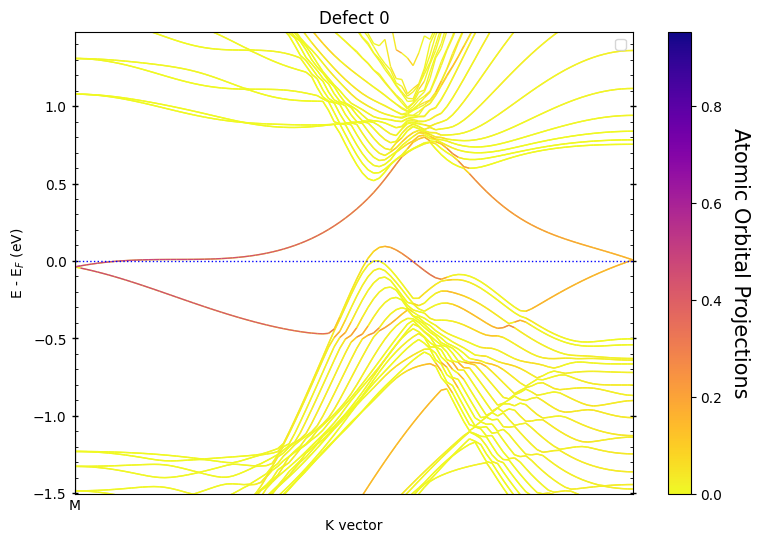

If you want more detailed logs, set verbose to 2 or more
____________________________________________________________________________________________________
 ____        ____
|  _ \ _   _|  _ \ _ __ ___   ___ __ _ _ __ 
| |_) | | | | |_) | '__/ _ \ / __/ _` | '__|
|  __/| |_| |  __/| | | (_) | (_| (_| | |   
|_|    \__, |_|   |_|  \___/ \___\__,_|_|
       |___/
A Python library for electronic structure pre/post-processing.

Version 6.4.6 created on Mar 6th, 2025

Please cite:
- Uthpala Herath, Pedram Tavadze, Xu He, Eric Bousquet, Sobhit Singh, Francisco Muñoz and Aldo Romero.,
  PyProcar: A Python library for electronic structure pre/post-processing.,
  Computer Physics Communications 251, 107080 (2020).

- L. Lang, P. Tavadze, A. Tellez, E. Bousquet, H. Xu, F. Muñoz, N. Vasquez, U. Herath, and A. H. Romero,
  Expanding PyProcar for new features, maintainability, and reliability.,
  Computer Physics Communications 297, 109063 (2024).

Developers:
- Francisco Muñoz
- Aldo Romero
- So

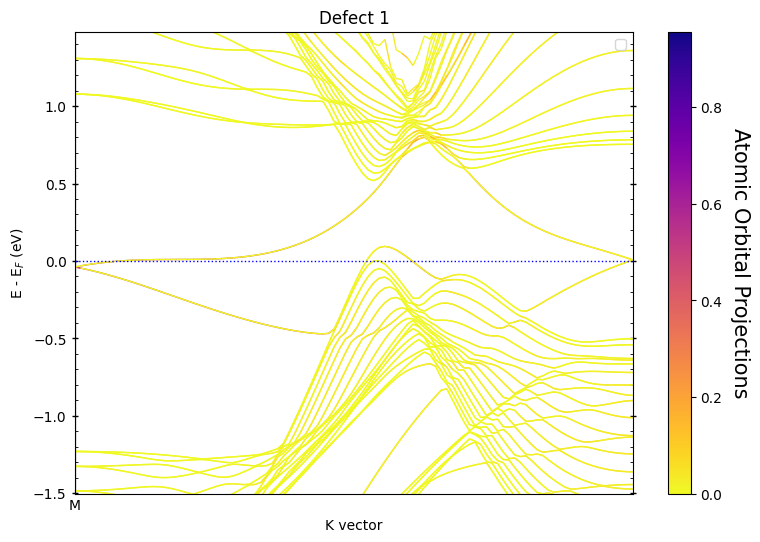


AUTOBANDS ANALYSIS COMPLETE!

What just happened:
✓ Geometric analysis identified structural features
✓ IPR calculations found localized electronic states
✓ Multiple plots generated (one per detected feature)
✓ Energy windows optimized automatically
✓ Color scales set to highlight relevant states
✓ Report file 'report.txt' generated with detailed analysis

Check the plots above and the generated report file!


In [3]:
# Run the autobands analysis - this is the magic command!
# It will automatically detect features and generate optimized plots

print("Running autobands analysis...")
print("This may take a moment as it analyzes the entire electronic structure...")
print()

# The main autobands function - everything is automated!
pyprocar.autobandsplot(
    code="vasp", 
    dirname=AUTO_DATA_DIR,
    fermi=3.0667
)

print("\n" + "="*60)
print("AUTOBANDS ANALYSIS COMPLETE!")
print("="*60)
print("\nWhat just happened:")
print("✓ Geometric analysis identified structural features")
print("✓ IPR calculations found localized electronic states") 
print("✓ Multiple plots generated (one per detected feature)")
print("✓ Energy windows optimized automatically")
print("✓ Color scales set to highlight relevant states")
print("✓ Report file 'report.txt' generated with detailed analysis")
print("\nCheck the plots above and the generated report file!")

## Step 3: Understanding the Results

Let's examine what autobands discovered and how to interpret the generated plots and reports.

### Reading the Analysis Report

The `report.txt` file contains detailed information about the automated analysis. Let's read it to understand what features were detected:


In [4]:
# Read and display the autobands analysis report
report_file = AUTO_DATA_DIR / "report.txt"

print("AUTOBANDS ANALYSIS REPORT")
print("=" * 50)

try:
    if report_file.exists():
        with open(report_file, 'r') as f:
            report_content = f.read()
        print(report_content)
    else:
        print("Report file not found. It may be generated in the current directory.")
        # Try current directory
        current_report = Path("report.txt")
        if current_report.exists():
            with open(current_report, 'r') as f:
                report_content = f.read()
            print(report_content)
        else:
            print("No report file found in current directory either.")
            
except Exception as e:
    print(f"Could not read report file: {e}")

print("\n" + "=" * 50)
print("KEY INFORMATION FROM THE REPORT:")
print("- Number of detected 'defects' (structural features)")
print("- Atom indices comprising each feature") 
print("- Energy ranges where localized states were found")
print("- IPR statistics for the localized states")
print("- Recommended plotting parameters that were used")


AUTOBANDS ANALYSIS REPORT
code = vasp
Spin polarized (collinear) = No
Energy window (guessed): (-1.50272841, 1.48125909)
-----

Defects?
0 [0]
1 [33]

Clusters? (including van der Waals layers)
None
----

Defects states within the energy window

Spin 0, defect 0 [0] 
band_indexes [159, 161, 163, 165, 169, 170, 171, 173, 175]

Spin 0, defect 1 [33] 
band_indexes [158, 160, 162, 164, 168, 169, 170, 172, 174]

----

Clusters states within the energy window

----



KEY INFORMATION FROM THE REPORT:
- Number of detected 'defects' (structural features)
- Atom indices comprising each feature
- Energy ranges where localized states were found
- IPR statistics for the localized states
- Recommended plotting parameters that were used


### Interpreting the Plots

The autobands analysis typically generates multiple plots, each focusing on a different detected feature:

1. **"Defect 0"**: Usually the top surface of the slab
2. **"Defect 1"**: Usually the bottom surface of the slab  
3. **Additional defects**: Any other features detected (grain boundaries, point defects, etc.)

#### What to Look For:

- **Colored bands**: These highlight projections onto the detected atoms
- **Energy range**: Automatically optimized to show relevant physics
- **Surface states**: Often appear as bands crossing the bulk band gap
- **Dirac cones**: Linear dispersion typical of topological surface states
- **Localization**: Strong color intensity indicates high localization on the feature atoms

### Comparison with Manual Analysis

Let's compare the autobands result with what we'd have to do manually:

MANUAL ANALYSIS - The Traditional Approach
Step 1: Plot basic band structure to survey the system
If you want more detailed logs, set verbose to 2 or more
____________________________________________________________________________________________________
 ____        ____
|  _ \ _   _|  _ \ _ __ ___   ___ __ _ _ __ 
| |_) | | | | |_) | '__/ _ \ / __/ _` | '__|
|  __/| |_| |  __/| | | (_) | (_| (_| | |   
|_|    \__, |_|   |_|  \___/ \___\__,_|_|
       |___/
A Python library for electronic structure pre/post-processing.

Version 6.4.6 created on Mar 6th, 2025

Please cite:
- Uthpala Herath, Pedram Tavadze, Xu He, Eric Bousquet, Sobhit Singh, Francisco Muñoz and Aldo Romero.,
  PyProcar: A Python library for electronic structure pre/post-processing.,
  Computer Physics Communications 251, 107080 (2020).

- L. Lang, P. Tavadze, A. Tellez, E. Bousquet, H. Xu, F. Muñoz, N. Vasquez, U. Herath, and A. H. Romero,
  Expanding PyProcar for new features, maintainability, and reliability.,
  Com

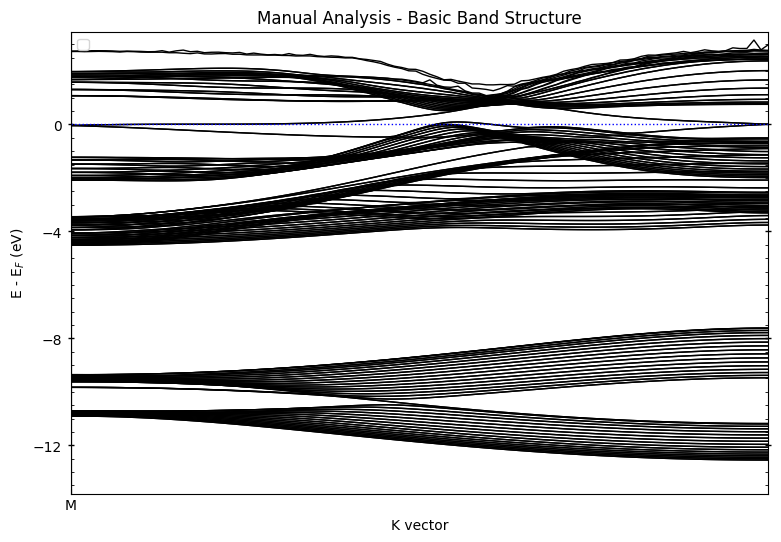


From this plot, we'd need to:
- Manually identify an appropriate energy window
- Guess which atoms might be relevant (surface atoms)
- Set color scale limits by trial and error
- Re-run multiple times to optimize the visualization

This process is time-consuming and error-prone!


In [5]:
# Manual analysis - what we'd have to do without autobands
print("MANUAL ANALYSIS - The Traditional Approach")
print("=" * 45)

# First, we'd need to plot a basic band structure to see the energy range
print("Step 1: Plot basic band structure to survey the system")
pyprocar.bandsplot(
    code="vasp",
    dirname=AUTO_DATA_DIR,
    mode="plain",
    fermi=3.0667,
    title="Manual Analysis - Basic Band Structure"
)

print("\nFrom this plot, we'd need to:")
print("- Manually identify an appropriate energy window")
print("- Guess which atoms might be relevant (surface atoms)")
print("- Set color scale limits by trial and error") 
print("- Re-run multiple times to optimize the visualization")
print("\nThis process is time-consuming and error-prone!")


Step 2: Manual attempt at surface state analysis
If you want more detailed logs, set verbose to 2 or more
____________________________________________________________________________________________________
 ____        ____
|  _ \ _   _|  _ \ _ __ ___   ___ __ _ _ __ 
| |_) | | | | |_) | '__/ _ \ / __/ _` | '__|
|  __/| |_| |  __/| | | (_) | (_| (_| | |   
|_|    \__, |_|   |_|  \___/ \___\__,_|_|
       |___/
A Python library for electronic structure pre/post-processing.

Version 6.4.6 created on Mar 6th, 2025

Please cite:
- Uthpala Herath, Pedram Tavadze, Xu He, Eric Bousquet, Sobhit Singh, Francisco Muñoz and Aldo Romero.,
  PyProcar: A Python library for electronic structure pre/post-processing.,
  Computer Physics Communications 251, 107080 (2020).

- L. Lang, P. Tavadze, A. Tellez, E. Bousquet, H. Xu, F. Muñoz, N. Vasquez, U. Herath, and A. H. Romero,
  Expanding PyProcar for new features, maintainability, and reliability.,
  Computer Physics Communications 297, 109063 (2024).


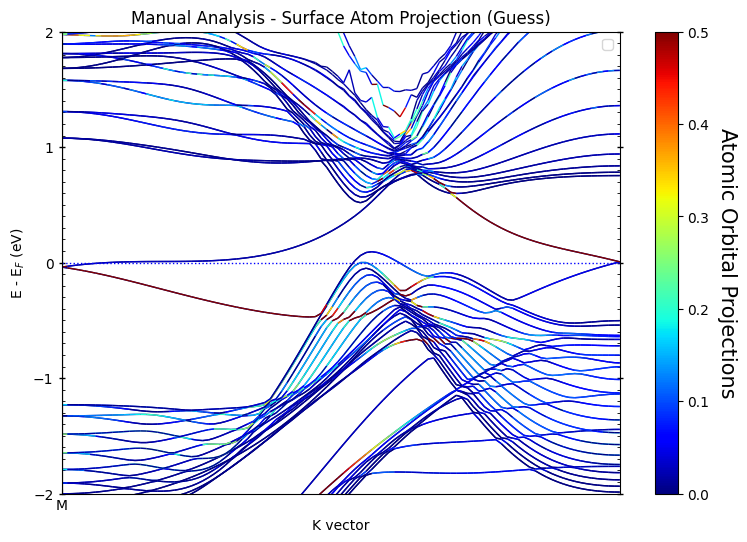


Manual approach challenges:
❌ Had to guess which atoms are surface atoms
❌ Had to guess appropriate energy window
❌ Had to guess color scale limits
❌ No guarantee these atoms actually host localized states
❌ Would need multiple iterations to optimize


In [6]:
# Manual approach: trying to guess surface atoms and energy windows
print("Step 2: Manual attempt at surface state analysis")

# We'd have to guess which atoms are surface atoms
# For a slab, these are typically the first and last few atoms
# But this requires knowledge of the atomic structure!

try:
    # Manual parametric plot - requires guessing parameters
    pyprocar.bandsplot(
        code="vasp",
        dirname=AUTO_DATA_DIR,
        mode="parametric",
        fermi=3.0667,
        atoms=[0, 1, 2],  # Guessing the first few atoms are surface atoms
        elimit=[-2, 2],   # Guessing an energy window around the Fermi level
        clim=[0, 0.5],    # Guessing color scale limits
        title="Manual Analysis - Surface Atom Projection (Guess)"
    )
    
    print("\nManual approach challenges:")
    print("❌ Had to guess which atoms are surface atoms")
    print("❌ Had to guess appropriate energy window") 
    print("❌ Had to guess color scale limits")
    print("❌ No guarantee these atoms actually host localized states")
    print("❌ Would need multiple iterations to optimize")
    
except Exception as e:
    print(f"Manual analysis failed: {e}")
    print("This demonstrates why automated analysis is so valuable!")


## Summary and Key Takeaways

### What We've Learned About Autobands

1. **🚀 Automation Power**: Autobands eliminates tedious manual analysis by automatically:
   - Detecting structural features (surfaces, defects, interfaces)
   - Computing IPR to identify localized electronic states
   - Optimizing energy windows and color scales
   - Generating comprehensive analysis reports

2. **🧠 Scientific Foundation**: Based on solid physics principles:
   - IPR quantifies electronic state localization
   - Geometric analysis identifies relevant atoms
   - Correlation between structure and electronic properties

3. **💡 Practical Benefits**: Saves time and reduces errors:
   - No need to guess atom indices or energy windows
   - Consistent, reproducible analysis protocols
   - Immediate insights into complex electronic structures

### When Autobands Shines

- **Surface science**: Topological surface states, surface reconstructions
- **Defect physics**: Point defects, vacancy states, impurity levels  
- **Interface studies**: Heterostructures, grain boundaries
- **2D materials**: Edge states, twist-angle effects
- **Unknown systems**: Exploratory analysis of new materials

### The Bigger Picture

Autobands represents a new paradigm in computational materials science:
- **From manual → automated analysis**
- **From guesswork → algorithm-driven insights**  
- **From time-consuming → immediate results**
- **From expert-only → accessible to all users**

### Looking Forward

As algorithms improve, expect even more sophisticated automatic analysis:
- Better feature detection algorithms
- More sophisticated IPR-based analysis
- Integration with machine learning
- Automated interpretation and reporting
